In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings

warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

plt.style.use('ggplot')
%matplotlib inline

# Objetivo

Pretendemos estudar o comportamento das vendas diárias de uma empresa com 4 unidades diferentes.
Entender o comportamento dos dados será vital para tentarmos gerar um modelo que consiga 'prever' os números dado um intervalo de confiança.

Esse processo pode ser o início de um processo orçamentário de qualidade, podendo servir como baliza para traçar estratégias mais assertivas.    




### DATASET:
    * O Dataset é composto por 3 unidades, que vamos supor que não estão concentradas geograficamente e seus dados dependes apenas do tempo.
    * Para criarmos uma imagem mais sólida do business, vamos supor uma megaloja de brinquedos (meu filho deu o exemplo).
    * O Dataset é composto por 323 observações. De 01/01/2018 até 19/11/2018.
    * Vamos tentar prever as vendas até o final do ano.

In [76]:
# Vamos ler o excel e usar a primeira coluna como index.

vendas = pd.read_excel('vendas.xlsx',
                        index_col=0)
vendas.head()

,UNIDADE 1,UNIDADE 2,UNIDADE 3
DATE,,,
2018-01-01,30133.690437,16811.969088,12007.010284
2018-01-02,22942.089204,14554.931264,14404.102961
2018-01-03,18799.724523,12071.650985,12233.279673
2018-01-04,25037.579141,13876.203899,12362.534142
2018-01-05,27413.151851,21498.419939,11689.193502


#### Vamos ver as vendas em totais mensais.

In [77]:
vendas_m = vendas.resample('M').sum()
display(round(vendas_m,2))

,UNIDADE 1,UNIDADE 2,UNIDADE 3
DATE,,,
2018-01-31,640088.57,442858.81,389605.69
2018-02-28,523978.01,422173.81,320728.31
2018-03-31,532144.02,423929.88,379769.51
2018-04-30,678813.55,498956.19,394152.06
2018-05-31,677066.73,490445.16,397217.11
2018-06-30,660067.75,460193.31,382969.22
2018-07-31,651486.70,453626.90,389562.57
2018-08-31,703840.52,497679.53,393467.95
2018-09-30,682149.69,555042.77,406439.26


## Primeira análise - Análise visual dos dados diários.
* Objetivo principal é detectar visualmente estacionariedade, tendências e sazonalidades

Como observado, temos indícios que as séries são estacionárias. Estacionariedade é uma característica das séries temporais que necessariamente deve estar presente para o modelo objetivo do trabalho. Há maneiras de estacionarizar uma série de dados, mas não se fez necessário neste sample de dados.
 * Estacionariedade = Média, variância e estrutura de correlação não são função do tempo.

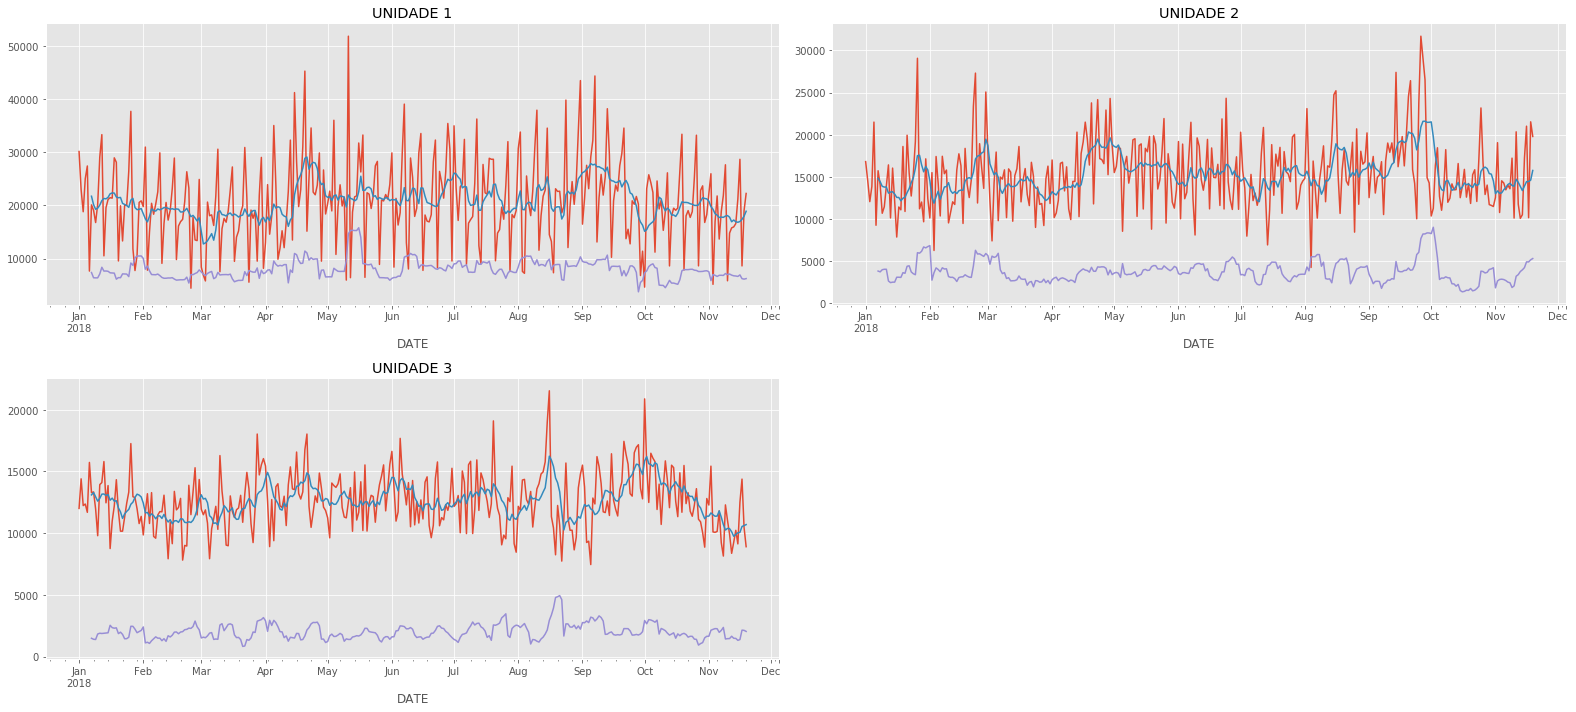

In [94]:
plt.figure(1, figsize=(22, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    vendas[vendas.columns[i]].plot()
    mov_avg = vendas[vendas.columns[i]].rolling(window=7).mean()
    mov_std = vendas[vendas.columns[i]].rolling(window=7).std()
    mov_avg.plot()
    mov_std.plot()
    
    plt.title(vendas.columns[i])

plt.tight_layout()

## Segunda análise - Teste matemático para provar a estacionariedade.

* Utilizando o teste aumentado de Dick Fuller podemos "detectar" a estacionariedade dos dados.
* Se p-valor <= 0.05 há estacionariedade. 

In [95]:
lista = ['Test Statistic', 'p-value',
        'Number of lags used', 'Observations']
colunas = vendas.columns
df = pd.DataFrame(index=lista, columns=colunas)
for i in range(3):
    result = adfuller(vendas[vendas.columns[i]])
    aux = result[:4]
    df[vendas.columns[i]] = aux
df

,UNIDADE 1,UNIDADE 2,UNIDADE 3
Test Statistic,-2.744892,-3.863715,-3.757033
p-value,0.066587,0.002319,0.003379
Number of lags used,13.000000,17.000000,9.000000
Observations,309.000000,305.000000,313.000000


### Estacionarizando uma série.

Como nossas vendas da Unidade 1 não se provou estacionária, podemos manipulá-la como o log natural dos valores observados.
Realizando novamente o teste temos a tão desejada estacionariedade.

Lembrando que agora temos um padrão diferente que deve ser convertido no final... 

In [96]:
vendas_log = np.log(vendas)
for i in range(3):
    result = adfuller(vendas_log[vendas_log.columns[i]])
    aux = result[:4]
    df[vendas.columns[i]] = aux
df

,UNIDADE 1,UNIDADE 2,UNIDADE 3
Test Statistic,-3.037658,-3.867341,-3.640278
p-value,0.031524,0.002289,0.005036
Number of lags used,14.000000,14.000000,9.000000
Observations,308.000000,308.000000,313.000000


## Terceira análise - Decomposição das séries de vendas diárias
Detectar tendências e sazonalidades dos dados.
Cada plot é composto por 4 mini gráficos:
   * 1º- Os dados diários observados.
   * 2º- Linha de tendência dos dados.
   * 3º- Sazonalidade percebida
   * 4º- Resultados que não podem ser explicados pela tendência ou sazonalidade.

'UNIDADE 1'

'UNIDADE 2'

'UNIDADE 3'

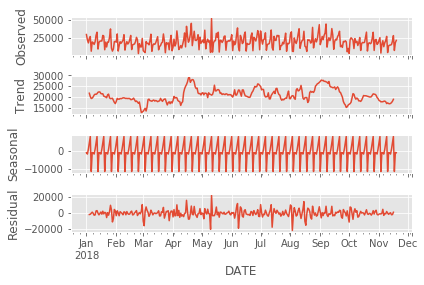

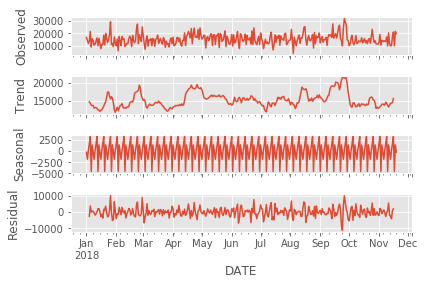

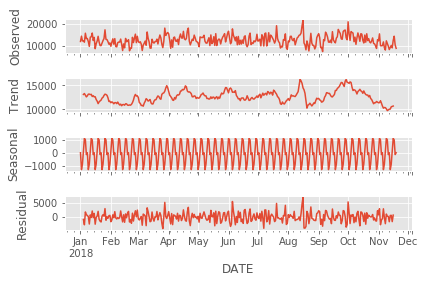

In [98]:
for i in range(3):
    decoposition = seasonal_decompose(vendas[vendas.columns[i]], model ='additive')
    decoposition.plot()
    display(vendas.columns[i])
    
plt.tight_layout()

## Quarta análise - Orbservando a autocorrelação e autocorrelação parcial

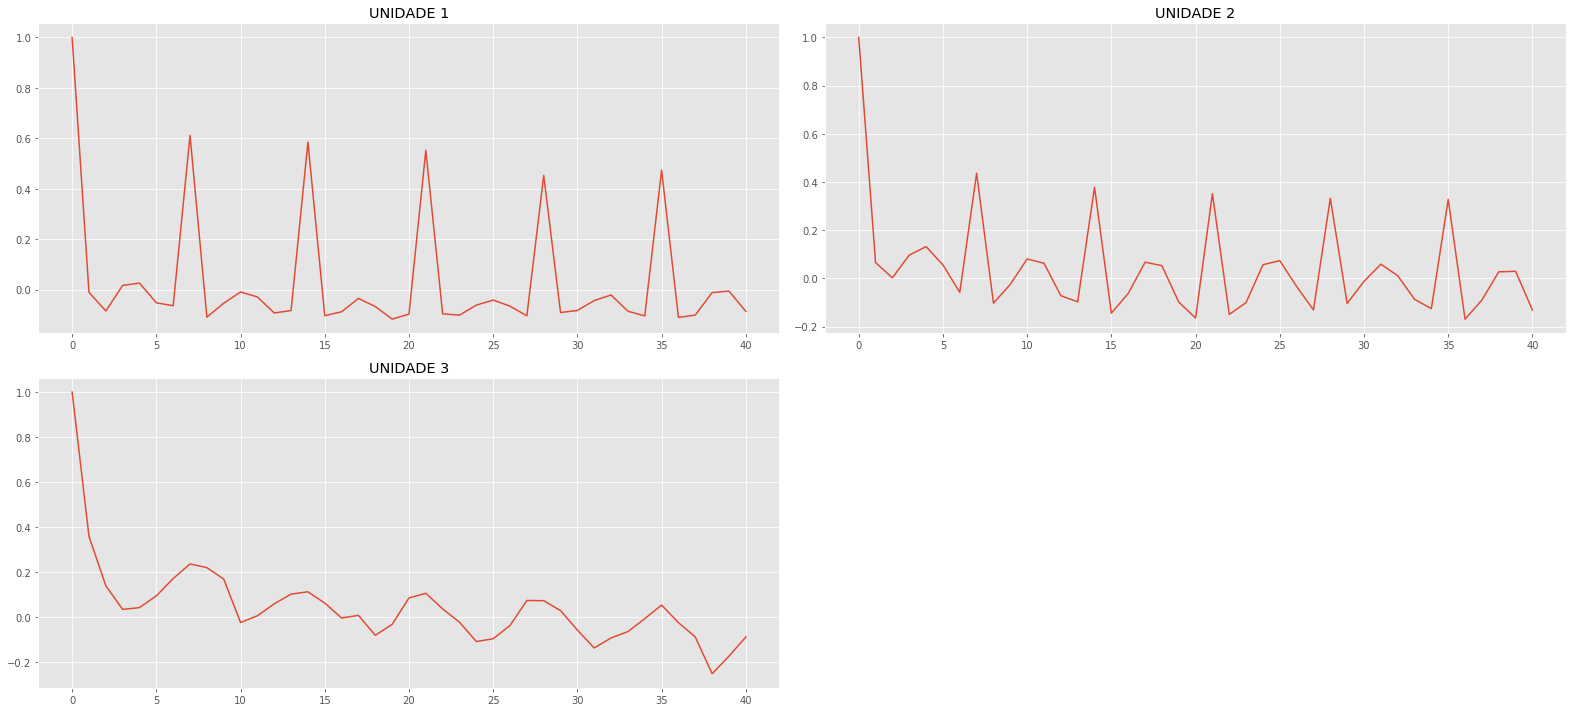

In [103]:
plt.figure(1, figsize=(22, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    acf_x = acf(vendas_log[vendas_log.columns[i]])
    plt.plot(acf_x)
    plt.title(vendas_log.columns[i])

plt.tight_layout()

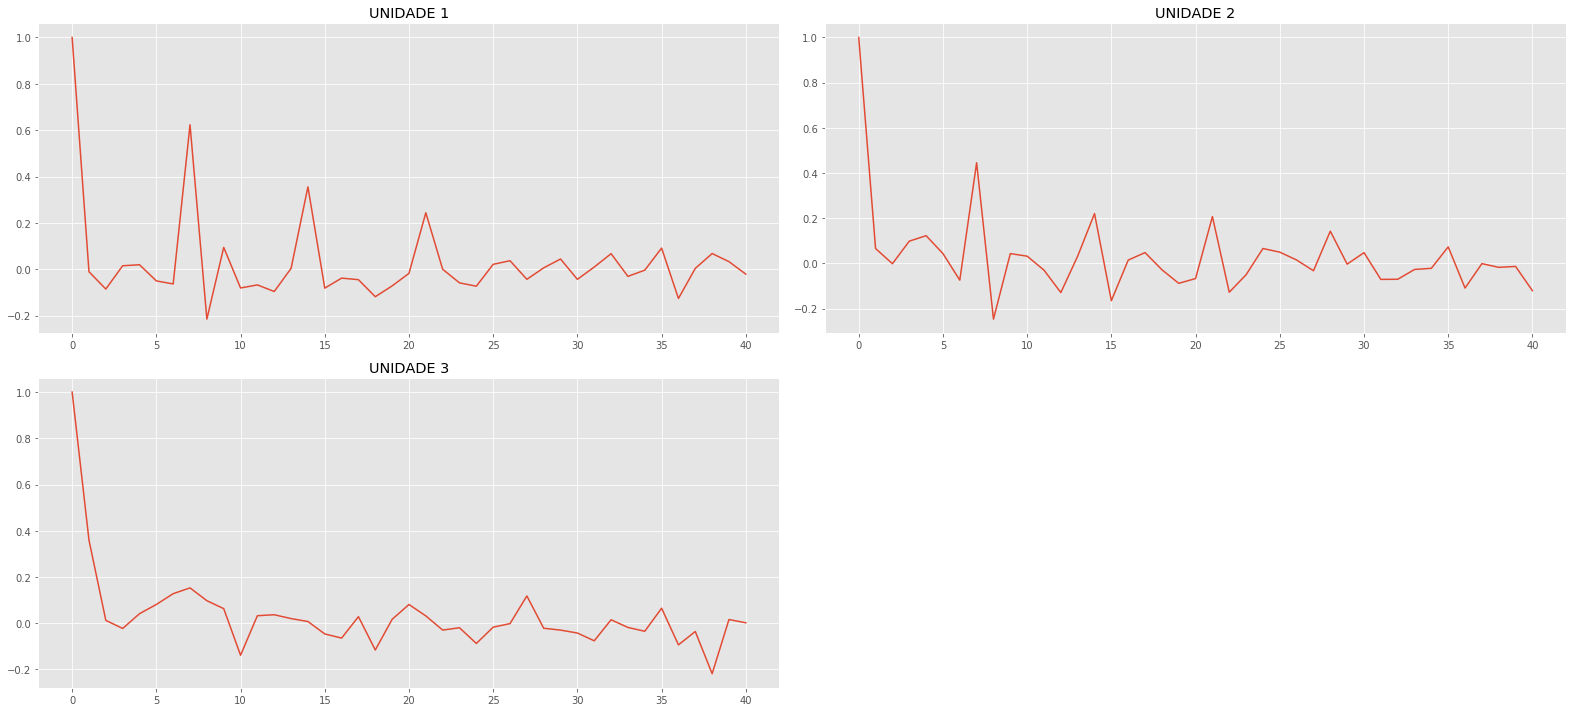

In [104]:
plt.figure(1, figsize=(22, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    pacf_x = pacf(vendas_log[vendas_log.columns[i]])
    plt.plot(pacf_x)
    plt.title(vendas_log.columns[i])

plt.tight_layout()

# Iniciando o modelo.

* Para tentarmos modelar os dados diários usaremos o modelo de auto regressão integrado com médias móveis (ARIMA)
* Este modelo usará a observação dos últimos 7 dias e a média móvel de 2 dias para gerar sua previsão.
* Geraremos o modelo e o compararemos com os dados observados para detectar se ele modela bem o que já passou...
* em azul... o modelo e em laranja os dados observados.

,UNIDADE 1,UNIDADE 2,UNIDADE 3
Mape %,2.497362,1.952497,1.387222


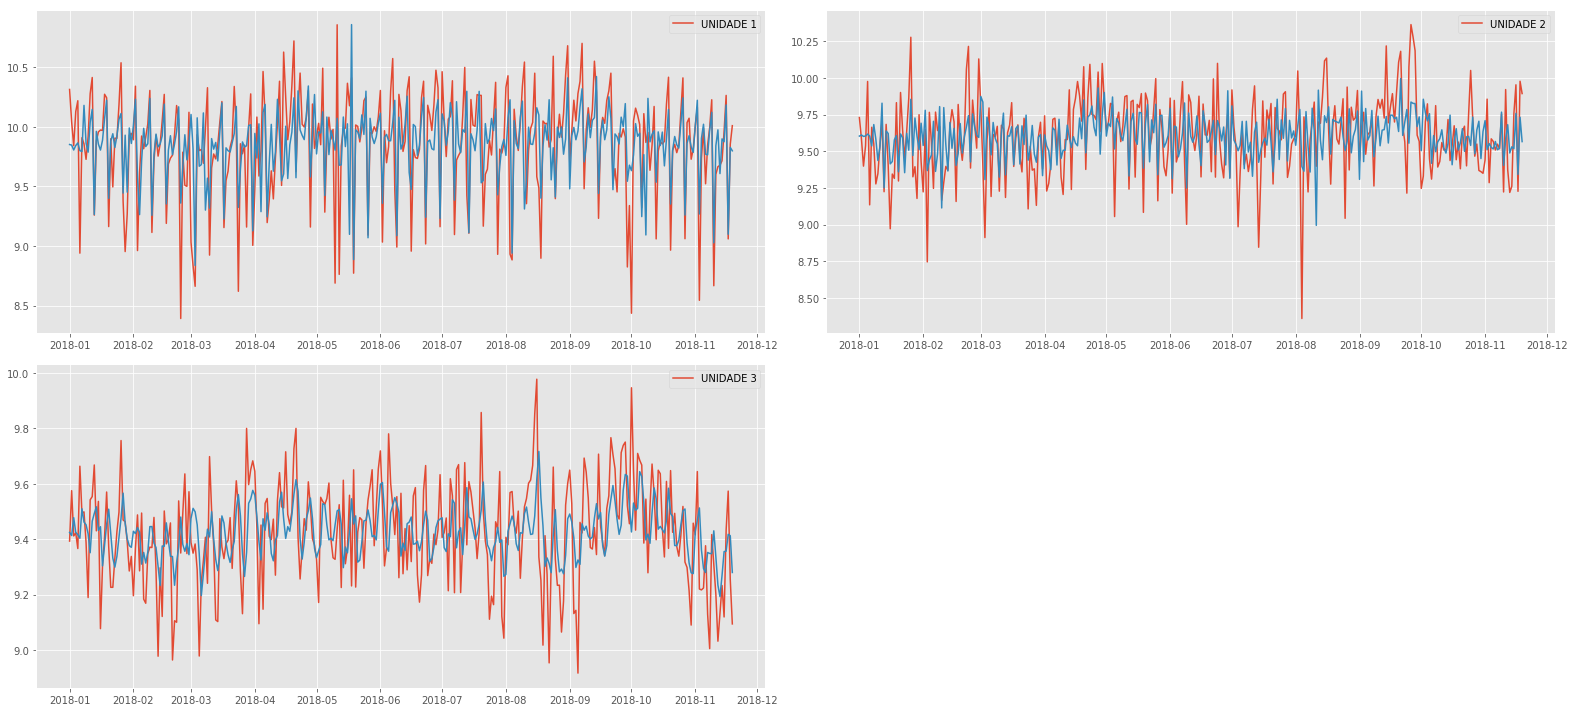

In [108]:
def mape(y_true, y_pred): # Mean Absolute percentage error
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

diagnostico = []

df_mape = pd.DataFrame(index=['Mape %'], columns=vendas.columns)

plt.figure(1, figsize=(22, 10))

for i in range(3):
    plt.subplot(2,2,i+1)
    model = ARIMA(vendas_log[vendas_log.columns[i]], order=(7,0,2), freq ='D')
    h = model.fit()
    
    df_mape[vendas_log.columns[i]] = mape(vendas_log[vendas_log.columns[i]].values,h.fittedvalues)
    
    plt.plot(vendas_log[vendas_log.columns[i]])
    plt.plot(h.fittedvalues)    
    plt.legend()
    
    diagnostico.append(h)    
plt.tight_layout()

df_mape

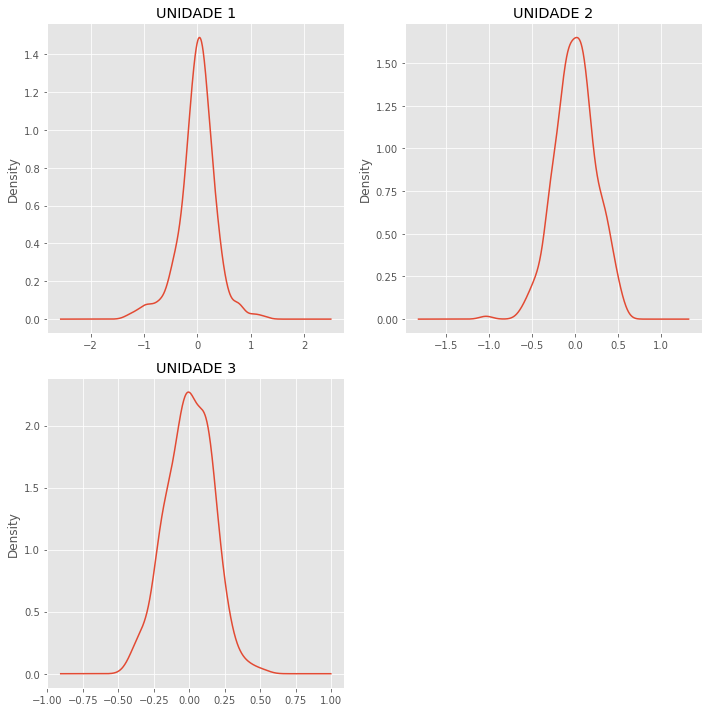

In [125]:
plt.figure(1, figsize=(10, 10))

for i in range(3):
    plt.subplot(2,2,i+1)
    diagnostico[i].resid.plot.kde()
    plt.title(vendas_log.columns[i])

plt.tight_layout()
    

,UNIDADE 1,UNIDADE 2,UNIDADE 3
2018-12-27,10.152864,9.536236,9.179808
2018-12-28,10.265112,9.594973,9.213245
2018-12-29,9.121625,9.177339,9.206941
2018-12-30,9.911340,9.513338,9.176841
2018-12-31,9.907532,9.420278,9.175810


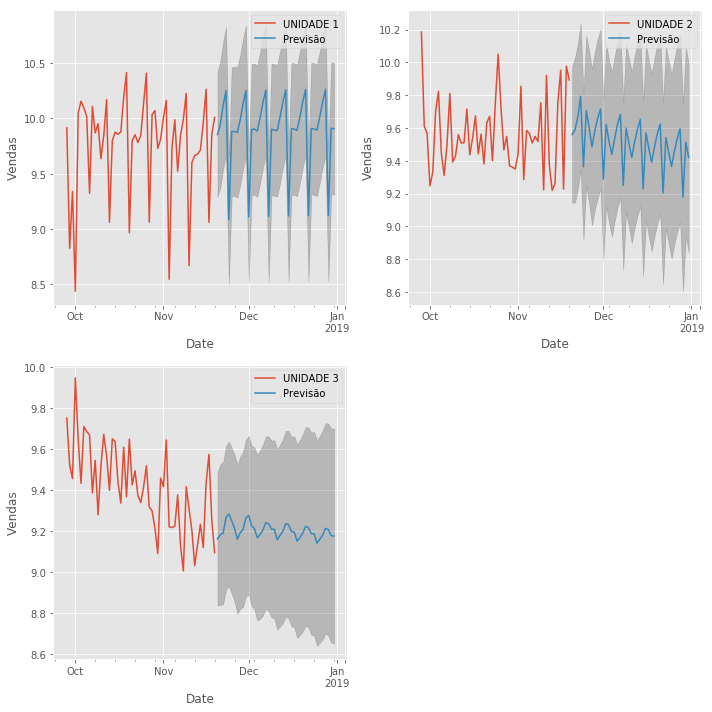

In [160]:
out = []

plt.figure(1, figsize=(10, 10))

for i in range(3):
    plt.subplot(2,2,i+1)
    pred_uc = diagnostico[i].get_forecast(steps=42)
    pred_ci = pred_uc.conf_int()
    ax = vendas_log[vendas_log.columns[i]][270:].plot()
    
    pred_uc.predicted_mean.plot(ax=ax, label='Previsão')
    
    ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=0.2)
    
    prev_c = pd.DataFrame(pred_uc.predicted_mean, columns=[vendas_log.columns[i]])
    if i==0:
        out = prev_c
    else:
        out = pd.concat([out, prev_c],axis=1, sort=False)
    
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Vendas')
    plt.legend()
    
plt.tight_layout()

In [162]:
final = pd.concat([vendas_log, out],axis=0, sort=False)
final = np.exp(final)

final.resample('M').sum()

,UNIDADE 1,UNIDADE 2,UNIDADE 3
2018-01-31,640088.573921,442858.805047,389605.694415
2018-02-28,523978.010311,422173.807534,320728.306783
2018-03-31,532144.016251,423929.879922,379769.507419
2018-04-30,678813.552246,498956.187341,394152.063479
2018-05-31,677066.728327,490445.161657,397217.110070
2018-06-30,660067.748842,460193.313404,382969.222138
2018-07-31,651486.695732,453626.895488,389562.573680
2018-08-31,703840.519539,497679.533488,393467.949390
2018-09-30,682149.685779,555042.769251,406439.264270
2018-10-31,611252.599432,436933.515153,414853.436636
